<a href="https://colab.research.google.com/github/chinnis18/ASD/blob/main/ASD(ML_project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/'

 Autistic  'Colab Notebooks'


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
data_dir = '/content/drive/MyDrive/Autistic'  # Update this to your dataset path

In [ ]:
import tensorflow as tf

# Ensure data_dir is the correct path to your dataset
data_dir = '/content/drive/MyDrive/Autistic'  # Double-check this path!

# Verify the directory exists and contains images
import os
if not os.path.exists(data_dir):
    print(f"Error: Directory not found: {data_dir}")
else:
    image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.bmp', '.gif', '.jpeg', '.jpg', '.png'))]
    if not image_files:
        print(f"Error: No images found in directory: {data_dir}")
    else:
        print(f"Found {len(image_files)} image files in {data_dir}")

dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/Autistic')

num_classes = len(dataset.class_names)
print(f"Number of classes: {num_classes}")

Error: No images found in directory: /content/drive/MyDrive/Autistic
Found 1954 files belonging to 2 classes.
Number of classes: 2


In [ ]:
import os

class_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name)))
                for class_name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, class_name))}

for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


Non_Autistic: 1047 images
Autistic: 907 images


In [ ]:
pip install split-folders

In [ ]:
import splitfolders  # Library for dataset splitting

# Define dataset path (original folder containing class folders)
dataset_path = "/content/drive/MyDrive/Autistic"

# Output directory (where train & test datasets will be saved)
output_path = "path/to/split_dataset"

# Perform the split (80% train, 20% test)
splitfolders.ratio(dataset_path, output=output_path, seed=42, ratio=(0.8, 0.2))

print("✅ Dataset successfully split into train & test sets!")


Copying files: 1954 files [01:05, 29.72 files/s] 

✅ Dataset successfully split into train & test sets!


In [ ]:
def count_images(dataset_path):
    total_images = 0
    class_image_counts = {}

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):  # Check if it's a folder (class)
            num_images = len(os.listdir(class_path))  # Count images in class
            class_image_counts[class_name] = num_images
            total_images += num_images

    return total_images, class_image_counts


In [ ]:
# Set your dataset paths
train_path = "/content/path/to/split_dataset/train"
test_path = "/content/path/to/split_dataset/val"

# Count images
train_total, train_classes = count_images(train_path)
test_total, test_classes = count_images(test_path)

# Print results
print(f"📌 Total Train Images: {train_total}")
print("Train Images per Class:", train_classes)

print(f"\n📌 Total Test Images: {test_total}")
print("Test Images per Class:", test_classes)


📌 Total Train Images: 1562
Train Images per Class: {'Non_Autistic': 837, 'Autistic': 725}

📌 Total Test Images: 392
Test Images per Class: {'Non_Autistic': 210, 'Autistic': 182}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

# Dataset Paths
train_data_path = "/content/path/to/split_dataset/train"  # Update this
test_data_path = "/content/path/to/split_dataset/val"    # Separate test dataset

# Get the number of classes dynamically
num_classes = len(os.listdir(train_data_path))  # Counts the number of subdirectories

# Load VGG16 with pre-trained weights, excluding top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-4:]:  # Unfreezing last 4 layers
    layer.trainable = True

# Custom classification head
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Initialize train_datagen here
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train & Validation Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # No shuffle for evaluation

# Print detected number of classes
print("Detected Classes:", train_generator.num_classes)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model using Test Data as Validation
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stopping]
)

# Evaluate on Test Dataset
test_loss, test_acc = model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 1562 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Detected Classes: 2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 51s 672ms/step - accuracy: 0.6243 - loss: 0.9350 - val_accuracy: 0.6327 - val_loss: 0.7090
Epoch 2/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.8267 - loss: 0.4135 - val_accuracy: 0.7270 - val_loss: 0.5404
Epoch 3/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 266ms/step - accuracy: 0.9061 - loss: 0.2179 - val_accuracy: 0.7781 - val_loss: 0.5368
Epoch 4/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 271ms/step - accuracy: 0.9199 - loss: 0.1938 - val_accuracy: 0.7577 - val_loss: 0.5710
Epoch 5/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step - accuracy: 0.9468 - loss: 0.1320 - val_accuracy: 0.7730 - val_loss: 0.5866
Epoch 6/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.9669 - loss: 0.1040 - val_accuracy: 0.7500 - val_loss: 0.9220
Epoch 7/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.9662 - loss: 0.0822 - val_accuracy: 0.7781 - val_loss: 0.7208
Epoch 8/15
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.9861 - loss: 0.0449 - val_accu

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step


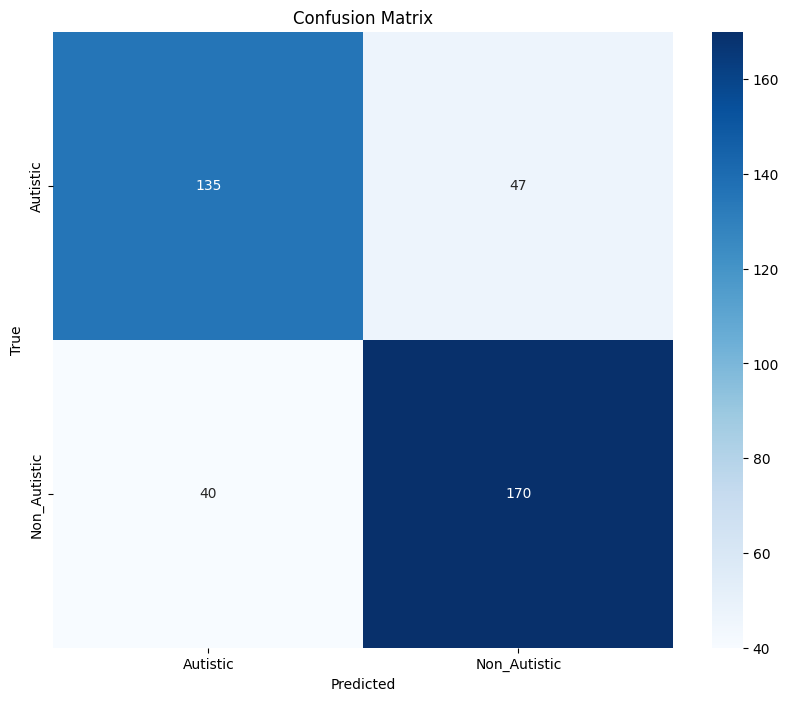

Classification Report:

              precision    recall  f1-score   support

    Autistic       0.77      0.74      0.76       182
Non_Autistic       0.78      0.81      0.80       210

    accuracy                           0.78       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.78      0.78      0.78       392



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict the probabilities for the test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


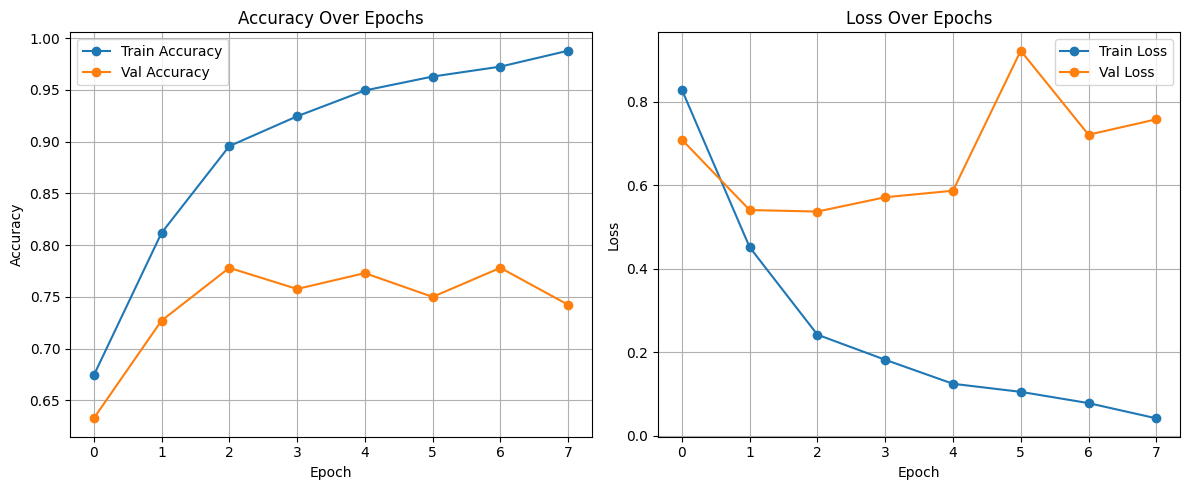

In [ ]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Dataset Paths
train_data_path = "/content/path/to/split_dataset/train"  # Update this
test_data_path = "/content/path/to/split_dataset/val"    # Independent test dataset

# Get the number of classes dynamically
num_classes = len(os.listdir(train_data_path))  # Counts the number of subdirectories

# Load InceptionV3 with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 15 layers for fine-tuning
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model with AdamW optimizer
optimizer = AdamW(learning_rate=0.0003, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


test_datagen = ImageDataGenerator(rescale=1./255)

# Train and Test Generators
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)  # No shuffle for evaluation

# Print detected classes
print("Detected Classes:", train_generator.num_classes)

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train Model using Test Data as Validation
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on Test Dataset
test_loss, test_acc = model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Found 1562 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Detected Classes: 2
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 733ms/step - accuracy: 0.6204 - loss: 1.1105 - val_accuracy: 0.7143 - val_loss: 0.5731 - learning_rate: 3.0000e-04
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.7701 - loss: 0.5497 - val_accuracy: 0.7474 - val_loss: 0.5177 - learning_rate: 3.0000e-04
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.8204 - loss: 0.4425 - val_accuracy: 0.7194 - val_loss: 0.5841 - learning_rate: 3.0000e-04
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.8648 - loss: 0.3242 - val_accuracy: 0.7526 - val_loss: 0.5186 - learning_rate: 3.0000e-04
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.8977 - loss: 0.2501 - val_accuracy: 0.7296 - val_loss: 0.5786 - learning_rate: 3.0000e-04
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.9057 - loss: 0.2019 - val_accuracy: 0.7704 - val_loss: 0.5360 - learning_rate: 6.0000e-05
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.9377 -

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 667ms/step


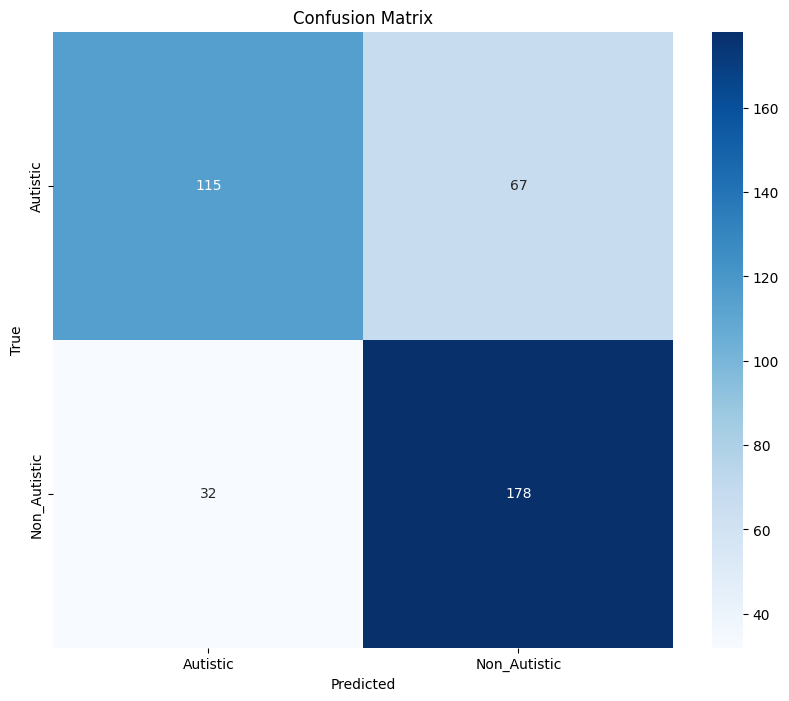

Classification Report:

              precision    recall  f1-score   support

    Autistic       0.78      0.63      0.70       182
Non_Autistic       0.73      0.85      0.78       210

    accuracy                           0.75       392
   macro avg       0.75      0.74      0.74       392
weighted avg       0.75      0.75      0.74       392



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict the probabilities for the test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

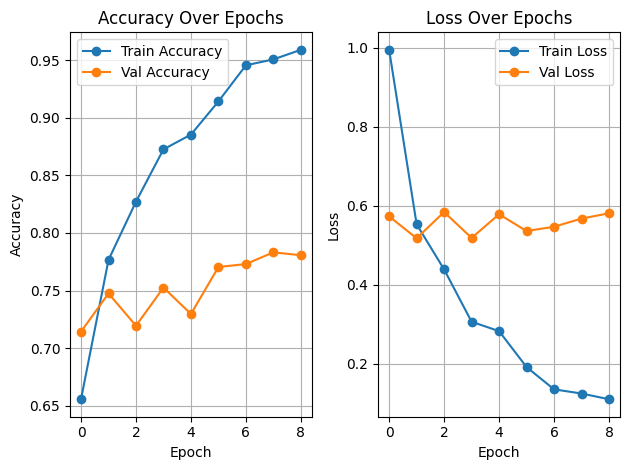

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np

# Load pre-trained InceptionV3 without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load image data
generator = datagen.flow_from_directory(
    '/content/path/to/split_dataset',  # train or test directory
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Extract features
features = model.predict(generator, verbose=1)
labels = generator.classes  # Ground truth labels


Found 1954 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step


In [ ]:
# Flatten the features to feed into KNN
X_features = features.reshape(features.shape[0], -1)
y_labels = labels


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Step 2: Feature scaling (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Logistic Regression Model
log_reg = LogisticRegression(
    max_iter=1000,              # Increase if convergence warnings
    class_weight='balanced',   # Handle class imbalance
    solver='lbfgs',             # Suitable for multi-class
    multi_class='auto',
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)

# Step 4: Evaluation
y_pred = log_reg.predict(X_test_scaled)

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.6854
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81       313
           1       0.19      0.18      0.19        78

    accuracy                           0.69       391
   macro avg       0.50      0.50      0.50       391
weighted avg       0.68      0.69      0.68       391

Confusion Matrix:
 [[254  59]
 [ 64  14]]


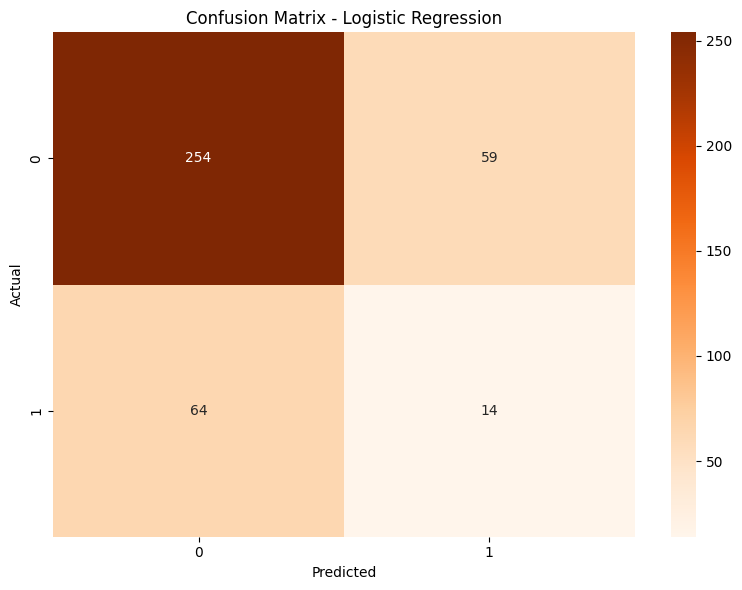

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Class labels (edit if needed)
class_names = np.unique(y_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


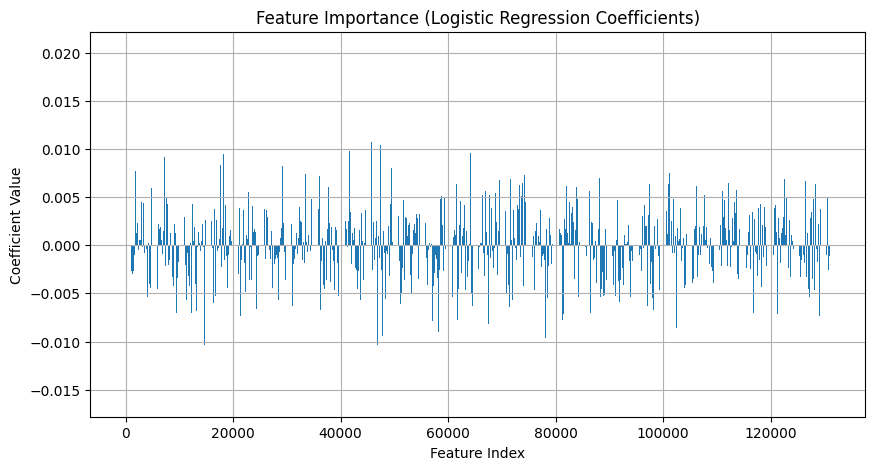

In [ ]:
# Only if you have interpretable features
coef = log_reg.coef_

# For binary classification
if coef.shape[0] == 1:
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(coef[0])), coef[0])
    plt.title('Feature Importance (Logistic Regression Coefficients)')
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.grid(True)
    plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Split the feature set
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Step 2: Normalize features (optional for Random Forest, but improves consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=None,             # Let trees grow until pure
    random_state=42,
    class_weight='balanced'     # Handle imbalance if any
)

rf_model.fit(X_train_scaled, y_train)

# Step 4: Evaluate
y_pred = rf_model.predict(X_test_scaled)

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8005
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       313
           1       0.50      0.01      0.03        78

    accuracy                           0.80       391
   macro avg       0.65      0.50      0.46       391
weighted avg       0.74      0.80      0.72       391



Confusion Matrix:
 [[254  59]
 [ 64  14]]


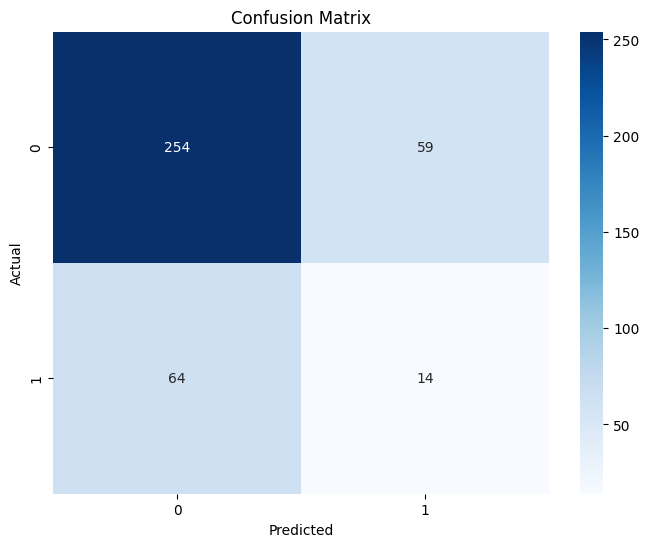


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       313
           1       0.19      0.18      0.19        78

    accuracy                           0.69       391
   macro avg       0.50      0.50      0.50       391
weighted avg       0.68      0.69      0.68       391



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: Class names (if available)
class_names = np.unique(y_labels)  # or use your custom list of class labels

# Print Confusion Matrix
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Optional: Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in class_names]))


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def predict_single_image(img_path, cnn_model, classifier, scaler, class_names):
    """Predicts the class of a single image using the CNN model and classifier."""
    img = image.load_img(img_path, target_size=(299, 299))  # Resize as per InceptionV3
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # Preprocessing specific to InceptionV3

    # Feature extraction
    features = cnn_model.predict(x)
    features = features.reshape(features.shape[0], -1)

    # Scale features and predict
    features_scaled = scaler.transform(features)
    prediction = classifier.predict(features_scaled)

    # Final predicted label
    predicted_class_index = prediction[0]
    predicted_class_label = class_names[predicted_class_index]

    print(f"Image: {img_path}")
    print(f"Predicted Class: {predicted_class_label}")

# Example usage
img_path = "/content/path/to/split_dataset/val/Non_Autistic/0235.jpg"
predict_single_image(img_path, model, log_reg, scaler, ['Autistic', 'Non_Autistic'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Image: /content/path/to/split_dataset/val/Non_Autistic/0235.jpg
Predicted Class: Non_Autistic


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.ensemble import RandomForestClassifier # Import RandomForestClassifier
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# ... (rest of your code) ...

def predict_single_image(img_path, cnn_model, classifier, scaler, class_names):
    """Predicts whether the image is Autistic or Non-Autistic."""
    # ... (function code remains the same) ...

# 👇 Example usage
img_path = "/content/path/to/split_dataset/val/Autistic/0253.jpg"

# Define rf_model and scaler here
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, class_weight='balanced')
# Assuming X_features and y_labels are defined in your previous code
# Adjust these lines if you have different feature extraction or training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
rf_model.fit(X_train_scaled, y_train) # Fit the model

predict_single_image(
    /content/path/to/split_dataset/val/Autistic/0253.jpg,
    cnn_model=model,
    classifier=rf_model,
    scaler=scaler,
    class_names=['Autistic', 'Non_Autistic']
)


SyntaxError: invalid imaginary literal (<ipython-input-30-4011ad031114>, line 27)

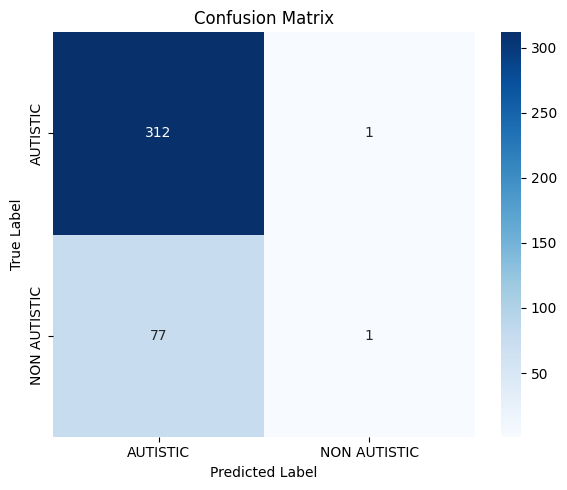

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class names
class_names = ["AUTISTIC", "NON AUTISTIC"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Accuracy: 0.8005
Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89       313
           1       0.50      0.01      0.03        78

    accuracy                           0.80       391
   macro avg       0.65      0.50      0.46       391
weighted avg       0.74      0.80      0.72       391



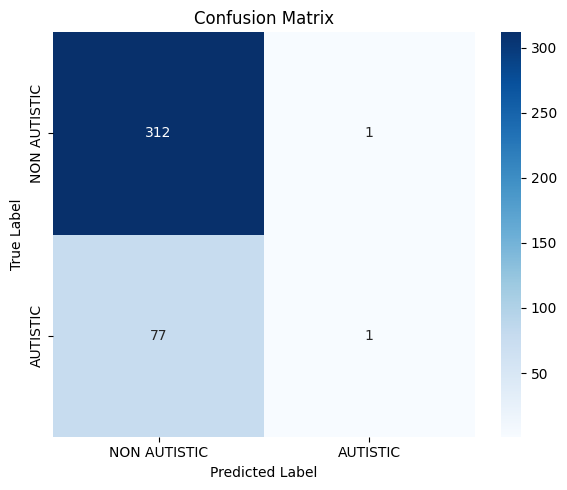

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Split the feature set
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Step 2: Normalize features (optional for RF)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)

# Step 4: Evaluate
y_pred = rf_model.predict(X_test_scaled)

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 5: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Make sure class_names match the actual encoding
class_names = ["NON AUTISTIC", "AUTISTIC"]  # 0 = NON AUTISTIC, 1 = AUTISTIC

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# Step 2: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Handle class imbalance
# Calculate scale_pos_weight = (# negative class) / (# positive class)
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Step 4: Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# Step 5: Predict and Evaluate
y_pred = xgb_model.predict(X_test_scaled)

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 6: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Make sure these match your label encoding!
class_names = ["NON AUTISTIC", "AUTISTIC"]  # 0 = NON AUTISTIC, 1 = AUTISTIC

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:13:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
!cat /proc/meminfo | grep Mem
!cat /proc/cpuinfo | grep "model name"


MemTotal:       13290452 kB
MemFree:        10965948 kB
MemAvailable:   11500816 kB
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
